In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
def set_timestep(df_ts: object) -> object:
    df_ts['time'] = df_ts['time'].str[:19]
    df_ts['time'] = pd.to_datetime(df_ts['time'], format="%Y-%m-%dT%H:%M:%S")
    df_ts.set_index('time', inplace=True)
    return df_ts


def ABS_SHAP(df_shap, df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index() #.drop('index', axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i], df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)], axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns = ['Variable', 'Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'red', 'blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k = pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable', 'SHAP_abs']
    k2 = k.merge(corr_df, left_on='Variable', right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs', ascending=True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable', y='SHAP_abs', color=colorlist, figsize=(5, 6), legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")

In [3]:
# load GEOVARIABLES
df_population = gpd.read_file(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\POP\Europe_installations.gpkg')
df_roads = gpd.read_file(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\OSM\EU_installations_osmnx.gpkg')
df_roads = df_roads[['id', 'primary', 'secondary', 'tertiary', 'residential', 'geometry']]
df_coast = pd.read_csv(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\coast\coast_dist.csv')
df_tpi = gpd.read_file(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\TPI\Pl_installations.gpkg')
df_land = gpd.read_file(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\Green\Pl_installations_green.gpkg')
df_build = pd.read_excel(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\OSM\Installations_2500m_buildings.xlsx')

Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.


In [ ]:
for df in [df_land, df_roads, df_population, df_build, df_coast]:
    try:
        df = df.drop('geometry', axis=1)
    except:
        pass
    df_tpi = df_tpi.merge(df, on='id')

df_tpi['roads'] = df_tpi['primary'] +  df_tpi['secondary'] + df_tpi['tertiary'] + df_tpi['residential']
df_geos = df_tpi.fillna(0)
df_geos

In [5]:
# TODO select only instas with full time data coverage

In [6]:
df_data = pd.read_csv(r'g:\Mój dysk\DS_Reports\Raporty_PL\Onet_2021\data_master\FINAL_DATA\20210913T141800_data.csv')
df_data = set_timestep(df_data)
df_data_vars = df_data[['id', 'pm10', 'pm25', 'windspeed', 'temperature']]

# select 3 winter months
df_data_winter = df_data_vars.loc[df_data_vars.index > '2020-12-01']
df_data_winter = df_data_winter.loc[df_data_winter.index < '2021-03-01']
df_data_winter = df_data_winter.loc[df_data_winter.pm25>0]

# groupby
df_data_winter_mean = df_data_winter.groupby('id').median()
df_data_winter_mean = df_data_winter_mean.dropna()
df_data_winter_mean = df_data_winter_mean.reset_index()

# data cleaning- outliers
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.pm25 > 1]
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.temperature < 15]
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.temperature > -10]
df_data_winter_mean = df_data_winter_mean.loc[df_data_winter_mean.pm25 < 70]
df_data_winter_mean

,id,pm10,pm25,windspeed,temperature
0,233,63.01,35.460,7.710,-0.050
1,236,49.91,30.190,7.850,3.900
2,237,73.82,31.415,7.450,-0.230
3,238,57.63,33.680,7.700,-0.560
4,239,76.17,40.650,7.700,-0.190
...,...,...,...,...,...
3042,82433,68.47,41.380,14.285,-1.065
3043,82440,57.72,34.820,7.100,0.230
3044,82466,32.68,21.660,11.900,1.890
3045,82485,49.41,33.030,9.970,-1.440


In [ ]:
# join with geos
df_data_winter_joined = df_geos.merge(df_data_winter_mean, on='id')
df_data_winter_joined = df_data_winter_joined.dropna(subset=['pm25'])
df_data_winter_joined = df_data_winter_joined.fillna(0)
df_data_winter_joined

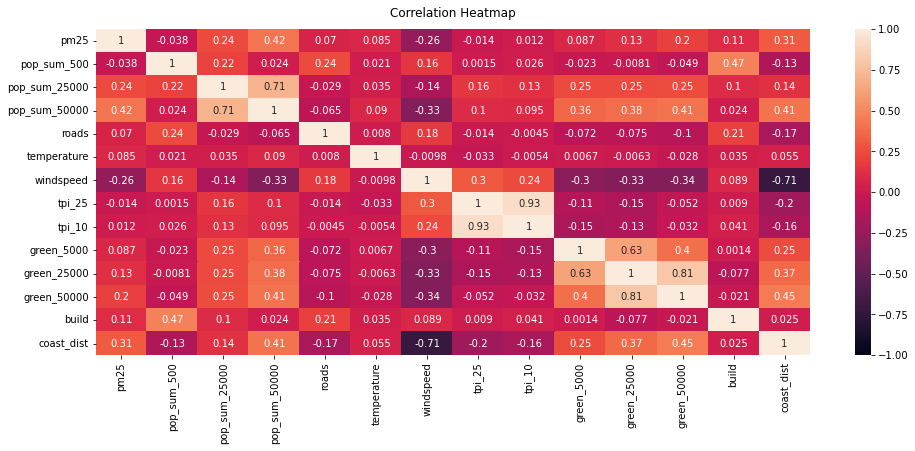

In [8]:
plt.figure(figsize=(16, 6))
features_corr = ['pm25', 'pop_sum_500', 'pop_sum_25000', 'pop_sum_50000', 'roads', 'temperature', 'windspeed',  'tpi_25', 'tpi_10', 'green_5000', 'green_25000', 'green_50000', 'build', 'coast_dist']
heatmap = sns.heatmap(df_data_winter_joined[features_corr].corr(), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
features = ['pop_sum_50000', 'roads', 'temperature', 'windspeed', 'tpi_25', 'green_500', 'green_5000', 'green_25000', 'build']

# scaler = StandardScaler()
# scaler.fit(df_data_winter_joined[features])
# X_scaled = scaler.transform(df_data_winter_joined[features])

In [9]:
# gridsearch - to jest dla mnie bez sensu, bo wychodzi na test slabiej, na train tez:/
param_grid = {  'bootstrap': [True], 'max_depth': [5, 10, None], 'max_features': ['auto', 'log2'],
                'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15]}

rfr = RandomForestRegressor(random_state = 1)
g_search = GridSearchCV(estimator = rfr, param_grid = param_grid,
                        cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(df_data_winter_joined[features], df_data_winter_joined['pm25'])

g_search.fit(X_train_ns, y_train_ns);
model = RandomForestRegressor(g_search.best_params_)

# Compute and print the metrics
print(g_search.score(X_train_ns, y_train_ns))
print(g_search.score(X_test_ns, y_test_ns))

model = RandomForestRegressor(n_estimators=200, random_state=0, max_depth=10)
model.fit(X_train_ns, y_train_ns)
print(model.score(X_train_ns, y_train_ns))
print(model.score(X_test_ns, y_test_ns))

0.9079301966826253
0.43489905748064417
0.7558780258883144
0.46417532098243


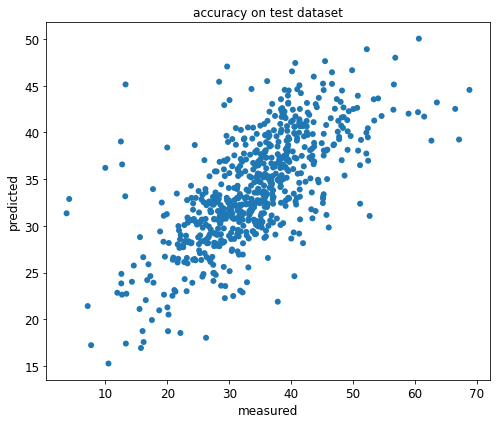

In [10]:
df_data_winter_joined['predicted'] = model.predict(df_data_winter_joined[features])
X_test_ns['predicted'] =  model.predict(X_test_ns)

def plot_scatter(x, y):
    fig, ax = plt.subplots(figsize=(7, 6))

    ax.scatter(x, y, marker='o', edgecolors='none')
    m, b = np.polyfit(x, y, 1)
    plt.title('accuracy on test dataset')
    ax.set_xlabel('measured', fontsize=12)
    ax.set_ylabel('predicted', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    # ax.annotate("r-squared = {:.3f}".format(r2))
    plt.tight_layout()
    # plt.savefig(scatrer_path)

plot_scatter(y_test_ns, X_test_ns['predicted'])
# df_data_winter_joined.to_file(r'g:\Dyski współdzielone\DATA SCIENCE\Data Analysis\Data\LandUseRegression\results\Pl_test.gpkg', driver='GPKG')

In [28]:
# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_data_winter_joined[features])

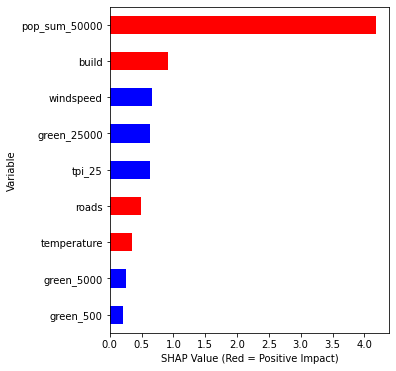

In [29]:
ABS_SHAP(shap_values.values,df_data_winter_joined[features])

In [ ]:
shap.plots.waterfall(shap_values[2591])

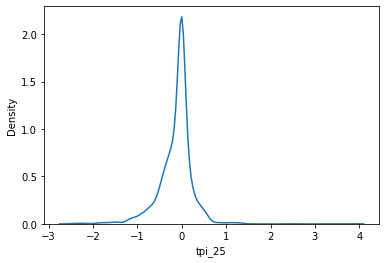

In [ ]:
# df_data_winter_joined_3 = df_data_winter_joined[['windspeed']]
hist = sns.kdeplot(data=df_data_winter_joined, x="tpi_25")

Text(0.5, 1.0, 'real')

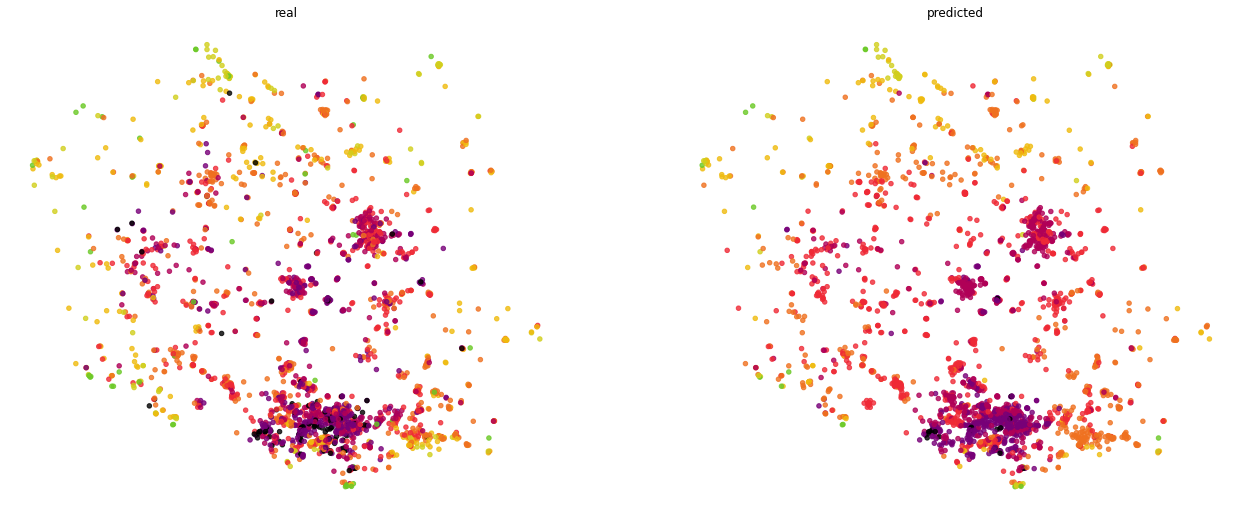

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,9))
levels_airly_caqi = [0, 15, 20, 25, 30, 35, 40, 50]
colors_airly_caqi = ['#6bc926', '#d1cf1e',  '#efbb0f', '#ef7120', '#EF2A36', '#B00057','#770078']

cmap_caqi, norm_caqi = matplotlib.colors.from_levels_and_colors(levels_airly_caqi, colors_airly_caqi)

df_data_winter_joined.plot(ax=ax1, column='pm25', alpha=0.8, cmap=cmap_caqi, norm=norm_caqi, markersize=20)
df_data_winter_joined.plot(ax=ax2, column='predicted', alpha=0.8, cmap=cmap_caqi, norm=norm_caqi, markersize=20)
ax2.axis("off")
ax1.axis("off")
ax2.set_title('predicted')
ax1.set_title('real')